In [ ]:
%load_ext autoreload
%autoreload 2
import sys
print(sys.executable)
import socket
print(socket.gethostname())
import os
os.chdir("/home/icb/alioguz.can/projects/4i_tests")
sys.path.append("/home/icb/alioguz.can/projects/4i_tests/cellseg")

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import squidpy as sq
import seaborn  as sns
import histomicstk as htk

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 206
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: VL Whole Slide Microscopy Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.36533.1592234914724322466371556613121619813816147
(0002,0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002,0012) Implementation Class UID            UI: 2.16.840.1
(0002,0013) Implementation Version Name         SH: 'SAM_1_2_0'
(0002,0016) Source Application Entity Title     AE: 'Segue_SCU'
-------------------------------------------------
(0008,0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'VOLUME', 'RESAMPLED']
(0008,0016) SOP Class UID                       UI: VL Whole Slide Microscopy Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.36533.1592234914724322466371556613121619813816147
(

Text(0.5, 1.0, 'Patient: E20012878#1#3#3')

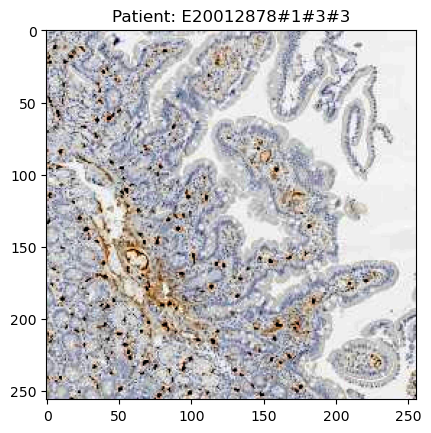

In [318]:
# Load DICOM file
dicom_path = "/home/icb/alioguz.can/projects/he_pathalogy/test_data/1.3.6.1.4.1.36533.1592234914724322466371556613121619813816147.dcm"

ds = pydicom.dcmread(dicom_path)
print(ds)

image = ds.pixel_array.astype(np.float32)
print("raw shape:", image.shape, "dtype:", image.dtype)

# Handle possible planar configuration
# (0 = interleaved RGB, 1 = planar)
if getattr(ds, "PlanarConfiguration", 0) == 1:
    image = np.moveaxis(image, 0, -1)  # (3, H, W) → (H, W, 3)
elif image.shape[-1] != 3:
    # If the 3 color planes are stacked differently (rare)
    image = np.transpose(image, (1, 2, 0))

# Now image is (N, H, W, 3)
if image.ndim == 3:
    image = image[None, ...]  # single tile case → add N=1

# --- Per-tile normalization ---
# Percentile normalization is more robust than /max()
p_low, p_high = 1, 99.5
for i in range(image.shape[0]):
    tile = image[i]
    lo, hi = np.percentile(tile, [p_low, p_high])
    tile = np.clip((tile - lo) / (hi - lo + 1e-6), 0, 1)
    image[i] = tile * 255.0

image = image.astype(np.uint8)
print("normalized shape:", image.shape, "dtype:", image.dtype)
plt.imshow(image[150])
plt.title(f"Patient: {ds.ContainerIdentifier}")

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt


def _ensure_uint8(img, SCALE_255=False):
    if img.dtype == np.uint8:
        return img
    if SCALE_255 or (img.dtype in (np.float32, np.float64) and np.nanmax(img) <= 1.0 + 1e-6):
        img = np.clip(img, 0, 1) * 255.0
    return img.astype(np.uint8, copy=False)

def _compute_tile_scores(tiles_uint8):
    """
    Compute tissue presence scores for each tile using pure NumPy.

    Returns dict with arrays of shape (N,):
      - nonwhite_ratio
      - tissue_ratio
      - local_contrast
      - mean_intensity
    """
    if tiles_uint8.ndim != 4 or tiles_uint8.shape[-1] != 3:
        raise ValueError(f"Expecting (N, H, W, 3), got {tiles_uint8.shape}")

    N, H, W, _ = tiles_uint8.shape
    tiles_f = tiles_uint8.astype(np.float32, copy=False)

    R = tiles_f[..., 0]
    G = tiles_f[..., 1]
    B = tiles_f[..., 2]

    # Heuristic 1: nonwhite ratio
    nonwhite = np.any(tiles_uint8 < 240, axis=-1)                 # (N, H, W)
    nonwhite_ratio = nonwhite.reshape(N, -1).mean(axis=1)         # (N,)

    # Heuristic 2: tissue ratio using HSV S and V (computed in NumPy)
    maxc = np.maximum(np.maximum(R, G), B)
    minc = np.minimum(np.minimum(R, G), B)
    V = maxc                                                          # 0..255
    # S = (max - min)/max * 255, with S=0 when V==0
    denom = np.where(V == 0, 1.0, V)
    S = (maxc - minc) / denom * 255.0

    s_thresh = 15.0
    v_hi     = 250.0
    tissue_mask = (S >= s_thresh) & (V <= v_hi)
    tissue_ratio = tissue_mask.reshape(N, -1).mean(axis=1)

    # Heuristic 3: local contrast via grayscale std (ITU-R BT.601 luma)
    gray = (0.2989 * R + 0.5870 * G + 0.1140 * B)                  # (N, H, W)
    local_contrast = gray.reshape(N, -1).std(axis=1)
    mean_intensity = gray.reshape(N, -1).mean(axis=1)

    return {
        "nonwhite_ratio": nonwhite_ratio,
        "tissue_ratio": tissue_ratio,
        "local_contrast": local_contrast,
        "mean_intensity": mean_intensity,
    }

def find_full_tiles(
    tiles,
    SCALE_255=False,
    min_nonwhite_ratio=0.02,
    min_tissue_ratio=0.02,
    min_contrast=3.0,
):
    """
    Returns indices for tiles that likely contain tissue.

    Parameters
    ----------
    tiles : np.ndarray, shape (N, H, W, 3)
    SCALE_255 : bool
        If tiles are floats in [0, 1], set True to scale to [0, 255].
    min_nonwhite_ratio : float
        Minimum fraction of nonwhite pixels to keep a tile.
    min_tissue_ratio : float
        Minimum fraction of saturated pixels to keep a tile.
    min_contrast : float
        Minimum grayscale std per tile.

    Returns
    -------
    full_idx : np.ndarray of ints
        Indices of full tiles.
    scores : dict of np.ndarray
        Per tile metrics: nonwhite_ratio, tissue_ratio, local_contrast, mean_intensity.
    """
    tiles_u8 = _ensure_uint8(np.asarray(tiles), SCALE_255=SCALE_255)
    scores = _compute_tile_scores(tiles_u8)

    is_full = (
        (scores["nonwhite_ratio"] >= min_nonwhite_ratio) &
        (scores["tissue_ratio"]   >= min_tissue_ratio) &
        (scores["local_contrast"] >= min_contrast)
    )

    full_idx = np.flatnonzero(is_full)

    # Sort by tissue richness (tissue_ratio) for convenience
    order = np.argsort(-scores["tissue_ratio"][full_idx])
    full_idx = full_idx[order]

    print(f"Tiles total: {tiles.shape[0]}")
    print(f"Full tiles: {len(full_idx)}")
    return full_idx, scores

def plot_top_tiles(tiles, rank_scores, top_k=16, tile_titles=None):
    """
    Safe version: gracefully handles empty inputs (k == 0).
    """
    tiles = np.asarray(tiles)
    rank_scores = np.asarray(rank_scores)

    # Nothing to plot if no tiles or no scores
    if tiles.size == 0 or rank_scores.size == 0:
        print("No tiles to plot (received empty selection).")
        return

    N = tiles.shape[0]
    k = min(top_k, N)
    if k == 0:
        print("No tiles to plot (k == 0).")
        return

    order = np.argsort(-rank_scores)[:k]

    # Guard against degenerate layout (k could be 1)
    cols = max(1, int(math.ceil(math.sqrt(k))))
    rows = max(1, int(math.ceil(k / cols)))

    plt.figure(figsize=(3.2*cols, 3.2*rows))
    for i, idx in enumerate(order):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(tiles[idx].astype(np.uint8))
        title = f"idx {idx} | score {rank_scores[idx]:.3f}"
        if tile_titles is not None:
            title = f"{title}\n{tile_titles[idx]}"
        plt.title(title, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# ---------------------------
# Your original calls work unchanged:
full_idx, scores = find_full_tiles(image, SCALE_255=False)
plot_top_tiles(image[full_idx], scores["tissue_ratio"][full_idx], top_k=22)

In [ ]:
"""
Slide-specific H&E deconvolution + nuclei segmentation (no OpenCV; works on your tiles).

Why your first try looked bad:
- Using a fixed/canonical stain matrix often fails when staining or scanning varies.
- Better: estimate the stain matrix per slide (Macenko), then deconvolve, then segment nuclei from the H (hematoxylin) OD channel.

What this cell does:
1) Robust per-tile tissue mask (to ignore background while estimating stains).
2) Estimate a 2-stain Macenko matrix W (H & E) from tissue pixels.
3) Deconvolve to get hematoxylin optical-density (H_OD).
4) Segment nuclei from H_OD with Otsu threshold + cleanup + watershed split.
5) Returns masks and shows a quick overlay.

Inputs expected:
- `image`: your uint8 array with shape (N, 256, 256, 3) as prepared earlier.

Dependencies (install if missing):
  pip install scikit-image scipy numpy matplotlib
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import filters, morphology, measure, segmentation, feature, exposure, util, color

# ---------- Utilities ----------

def rgb_to_od(rgb_u8, I0=255.0):
    """Convert RGB uint8 (H,W,3) to optical density (H,W,3)."""
    # Add 1 to avoid log(0)
    rgb = rgb_u8.astype(np.float32)
    return -np.log((rgb + 1.0) / (I0 + 1.0))

def macenko_stain_matrix(rgb_u8, tissue_mask=None, I0=255.0, beta=0.15, alpha=1.0):
    """
    Estimate slide-specific 2-stain (H&E) matrix using Macenko.
    Returns W (3x3) with two columns for H & E and a third dummy column.

    Parameters
    ----------
    rgb_u8 : uint8 (H,W,3)
    tissue_mask : optional boolean (H,W) — restricts estimation to tissue pixels
    I0 : float — illumination white point (255 for uint8)
    beta : float — OD threshold to filter very light pixels (typ. 0.15)
    alpha : float — percentile for angle extremes (1 to 5 is common)

    Returns
    -------
    W : np.ndarray shape (3,3)   columns ~ [H, E, filler]
    """
    od = rgb_to_od(rgb_u8, I0=I0).reshape(-1, 3)  # (P,3)
    if tissue_mask is not None:
        od = od[tissue_mask.flatten()]

    # Filter pixels with low OD (background)
    od = od[np.all(od > beta, axis=1)]
    if od.size == 0:
        # Fallback to canonical H&E vectors (Ruifrok)
        W = np.array([[0.65, 0.07, 0.0],
                      [0.70, 0.99, 0.0],
                      [0.29, 0.11, 1.0]], dtype=np.float32)
        return W

    # SVD on centered OD
    od_centered = od - od.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(od_centered, full_matrices=False)
    # Top 2 PCs define the stain plane
    V = Vt[:2, :]  # (2,3)

    # Project OD onto plane and compute angles
    proj = od_centered @ V.T  # (P,2)
    angles = np.arctan2(proj[:, 1], proj[:, 0])

    # Robust extremes
    lo, hi = np.percentile(angles, [alpha, 100 - alpha])
    v1 = (V.T @ np.array([np.cos(lo), np.sin(lo)])).ravel()
    v2 = (V.T @ np.array([np.cos(hi), np.sin(hi)])).ravel()

    # Normalize stain vectors to unit length and ensure positive entries
    def _norm(v):
        v = v / (np.linalg.norm(v) + 1e-8)
        # enforce positive by flipping if needed (convention)
        if v[0] < 0: v = -v
        return v

    h_vec = _norm(v1)
    e_vec = _norm(v2)

    # Order heuristically so first is hematoxylin (higher blue component)
    if h_vec[2] < e_vec[2]:
        h_vec, e_vec = e_vec, h_vec

    # Third column as a filler to make 3x3 invertible
    # Use cross-product to span RGB space
    third = np.cross(h_vec, e_vec)
    if np.linalg.norm(third) < 1e-6:
        third = np.array([0.0, 0.0, 1.0], dtype=np.float32)
    third = third / (np.linalg.norm(third) + 1e-8)

    W = np.stack([h_vec, e_vec, third], axis=1).astype(np.float32)  # (3,3)
    return W

def separate_stains_od(rgb_u8, W, I0=255.0):
    """
    Deconvolve: OD = M @ C  ->  C = M^{-1} @ OD
    Returns channels (H, E, third) in OD, each (H,W).
    """
    H, Wd, _ = rgb_u8.shape
    od = rgb_to_od(rgb_u8, I0=I0).reshape(-1, 3).T                # (3,P)
    Minv = np.linalg.pinv(W)                                      # (3,3)
    C = Minv @ od                                                 # (3,P)
    C = np.maximum(C, 0.0)                                        # nonnegative concentrations
    Cimg = C.T.reshape(H, Wd, 3)                                  # (H,W,3)
    # Return H and E OD images (higher = more stain)
    return Cimg[..., 0], Cimg[..., 1], Cimg[..., 2]

def quick_tissue_mask(tile_u8, white_thresh=240, sat_thresh=10):
    """
    Coarse tissue mask using non-white and minimal saturation.
    """
    # Non-white
    nonwhite = np.any(tile_u8 < white_thresh, axis=-1)
    # Saturation from HSV
    hsv = color.rgb2hsv(tile_u8)
    sat = (hsv[..., 1] * 255).astype(np.float32)
    tissue = nonwhite & (sat >= sat_thresh)
    # Clean
    tissue = morphology.remove_small_objects(tissue, 64)
    tissue = morphology.remove_small_holes(tissue, 64)
    return tissue

# ---------- Example on one of your full tiles ----------

# Pick a tile; use one that you know has clear tissue
tile_idx = 150  # replace with any index from your `full_idx` list
tile = image[tile_idx]
# 1) Tissue mask for robust W estimation
tmask = quick_tissue_mask(tile)
# 2) Estimate slide-specific W with Macenko
W = macenko_stain_matrix(tile, tissue_mask=tmask, beta=0.15, alpha=1.0)
# 3) Deconvolution → H (hematoxylin) OD
H_od, E_od, _ = separate_stains_od(tile, W)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(np.clip(H_od, 0, np.percentile(H_od, 99)), cmap='gray'); plt.title("Hematoxylin OD"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(np.clip(E_od, 0, np.percentile(E_od, 99)), cmap='gray'); plt.title("Eosin OD"); plt.axis('off')
plt.show()

In [ ]:
test_tile = image[150]
print(test_tile.shape)

In [ ]:
test_tile_cont = test_tile[0]
sq_imgCont = sq.im.ImageContainer(test_tile_cont, layer="image", mask=None, dims="channels_last")
# smooth image
sq.im.process(sq_imgCont, layer="image", method="smooth", sigma=1)

# plot the result
fig, axes = plt.subplots(1, 2)
for layer, ax in zip(["image", "image_smooth"], axes):
    sq_imgCont.show(layer, ax=ax)
    ax.set_title(layer)

In [ ]:
vals = np.array(sq_imgCont["image_smooth"]).flatten()
print(np.min(vals), np.percentile(vals,[1,5,25,50,75,95,99,100]))

In [ ]:
def show_histogram(sq_imgCont, threshold_value=220, bins=50):
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    sq_imgCont.show("image", cmap="gray", ax=axes[0])
    sq_imgCont.show("image_smooth", cmap="gray", ax=axes[1])
    axes[2].imshow(sq_imgCont["image_smooth"][:, :, 0, 0] < threshold_value)
    _ = sns.histplot(np.array(sq_imgCont["image_smooth"]).flatten(), bins=bins, ax=axes[3])
    plt.tight_layout()

threshold_val = np.percentile(np.array(sq_imgCont["image_smooth"]).flatten(), 99)
print(threshold_val)
show_histogram(sq_imgCont, threshold_value=threshold_val, bins=500)

In [ ]:
sq.im.segment(img=sq_imgCont, layer="image_smooth", method="watershed", thresh=threshold_val, geq=False)
print(sq_imgCont)
print(f"Number of segments in crop: {len(np.unique(sq_imgCont['segmented_watershed']))}")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sq_imgCont.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("H&E")
axes[0].axis("on")   # show axis again
sq_imgCont.show("segmented_watershed", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")
axes[1].axis("on")   # show axis again
# segmentation mask inside the Squidpy ImageContainer
seg_mask = sq_imgCont["segmented_watershed"].values
# unique labels (0 = background)
labels = np.unique(seg_mask)
n_objects = len(labels) - (1 if 0 in labels else 0)
print(f"Number of objects identified: {n_objects}")

# Multiple tiles

In [235]:
import pydicom

path = "/home/icb/alioguz.can/projects/he_pathalogy"
for f in sorted([p for p in os.listdir(path) if p.endswith(".dcm")]):
    ds = pydicom.dcmread(os.path.join(path, f), stop_before_pixels=True)
    print(f"{f}:")
    print(f"  SOP Class UID  -> {ds.SOPClassUID.name}")
    print(f"  Frames         -> {ds.get('NumberOfFrames', 'N/A')}")
    print(f"  Rows x Cols    -> {ds.get('Rows', '?')} x {ds.get('Columns', '?')}")
    print()

1.3.6.1.4.1.36533.1592234914724322466371556613121619813816147.dcm:
  SOP Class UID  -> VL Whole Slide Microscopy Image Storage
  Frames         -> 221
  Rows x Cols    -> 256 x 256

1.3.6.1.4.1.36533.1917212221721117965124161586258981398778.dcm:
  SOP Class UID  -> VL Whole Slide Microscopy Image Storage
  Frames         -> 53116
  Rows x Cols    -> 256 x 256

1.3.6.1.4.1.36533.2191674324891037261163223632171561374523.dcm:
  SOP Class UID  -> VL Whole Slide Microscopy Image Storage
  Frames         -> 1
  Rows x Cols    -> 1387 x 1920

1.3.6.1.4.1.36533.2288197441572275138173326225510515910250.dcm:
  SOP Class UID  -> VL Whole Slide Microscopy Image Storage
  Frames         -> 3332
  Rows x Cols    -> 256 x 256

1.3.6.1.4.1.36533.2385223510419551671181766137100140115135226.dcm:
  SOP Class UID  -> VL Whole Slide Microscopy Image Storage
  Frames         -> 1
  Rows x Cols    -> 598 x 1484

1.3.6.1.4.1.36533.256823514110317875213188183621240994210.dcm:
  SOP Class UID  -> VL Whole Slide

In [236]:
# Load DICOM file
dicom_path = "/home/icb/alioguz.can/projects/he_pathalogy/1.3.6.1.4.1.36533.1592234914724322466371556613121619813816147.dcm"

ds = pydicom.dcmread(dicom_path)
image = ds.pixel_array.astype(np.float32)
# Handle possible planar configuration
# (0 = interleaved RGB, 1 = planar)
if getattr(ds, "PlanarConfiguration", 0) == 1:
    image = np.moveaxis(image, 0, -1)  # (3, H, W) → (H, W, 3)
elif image.shape[-1] != 3:
    # If the 3 color planes are stacked differently (rare)
    image = np.transpose(image, (1, 2, 0))

# Now image is (N, H, W, 3)
if image.ndim == 3:
    image = image[None, ...]  # single tile case → add N=1

# --- Per-tile normalization ---
# Percentile normalization is more robust than /max()
p_low, p_high = 1, 99.5
for i in range(image.shape[0]):
    tile = image[i]
    lo, hi = np.percentile(tile, [p_low, p_high])
    tile = np.clip((tile - lo) / (hi - lo + 1e-6), 0, 1)
    image[i] = tile * 255.0

image = image.astype(np.uint8)
print("normalized shape:", image.shape, "dtype:", image.dtype)
patient_id = ds.ContainerIdentifier.split("#")[0]
print(f"Patient: {patient_id}")

normalized shape: (221, 256, 256, 3) dtype: uint8
Patient: E20012878


In [237]:
top_k = 10
full_idx, scores = find_full_tiles(image, SCALE_255=False)
print(f"{len(full_idx)} files have signal, subsetting to {top_k} files.")
full_idx = full_idx[:top_k]
# plot_top_tiles(image[full_idx], scores["tissue_ratio"][full_idx], top_k=top_k)

Tiles total: 221
Full tiles: 21
21 files have signal, subsetting to 10 files.


In [238]:
E_od_list = []
for idx in full_idx:
    tile = image[idx]
    tmask = quick_tissue_mask(tile)
    W = macenko_stain_matrix(tile, tissue_mask=tmask, beta=0.15, alpha=1.0)
    H_od, E_od, _ = separate_stains_od(tile, W)
    E_od_list.append(E_od)
E_od_array = np.stack(E_od_list)

In [239]:
for i, arr in enumerate(E_od_array):
    sq_imgCont = sq.im.ImageContainer(arr, layer="image", mask=None, dims="channels_last")
    # smooth image
    sq.im.process(sq_imgCont, layer="image", method="smooth", sigma=1)
    threshold_val = np.percentile(np.array(sq_imgCont["image_smooth"]).flatten(), 99)
    sq.im.segment(img=sq_imgCont, layer="image_smooth", method="watershed", thresh=threshold_val, geq=True)
    # segmentation mask inside the Squidpy ImageContainer
    seg_mask = sq_imgCont["segmented_watershed"].values
    # unique labels (0 = background)
    labels = np.unique(seg_mask)
    n_objects = len(labels) - (1 if 0 in labels else 0)
    print(f"Tile {full_idx[i]}: Thresholding at {threshold_val} -> Number of objects identified: {n_objects}")
    
    # fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # sq_imgCont.show("image", channel=0, ax=axes[0], cmap="nipy_spectral_r")
    # _ = axes[0].set_title(f"H&E")
    # axes[0].axis("on")   # show axis again
    # sq_imgCont.show("segmented_watershed", interpolation="none", ax=axes[1])
    # _ = axes[1].set_title("segmentation")
    # axes[1].axis("on")   # show axis again

Tile 53: Thresholding at 5.845068454742432 -> Number of objects identified: 85
Tile 54: Thresholding at 5.178074836730957 -> Number of objects identified: 134
Tile 37: Thresholding at 77.30082702636719 -> Number of objects identified: 110
Tile 149: Thresholding at 7.0745930671691895 -> Number of objects identified: 127
Tile 150: Thresholding at 3.4734528064727783 -> Number of objects identified: 133
Tile 55: Thresholding at 231.48960876464844 -> Number of objects identified: 112
Tile 70: Thresholding at 4.7323784828186035 -> Number of objects identified: 140
Tile 167: Thresholding at 82.25691986083984 -> Number of objects identified: 84
Tile 71: Thresholding at 69.79873657226562 -> Number of objects identified: 104
Tile 165: Thresholding at 4.815406322479248 -> Number of objects identified: 123


SVS file

In [364]:
from pathlib import Path

Vendor: aperio
Objective power: 40
MPP X: 0.26315899999999998
MPP Y: 0.26315899999999998
Level count: 3
Level dimensions: ((48168, 33083), (12042, 8270), (3010, 2067))
Level downsamples: (1.0, 4.000181378476421, 16.003989764805915)
Patient: KO21000758#1#1#5


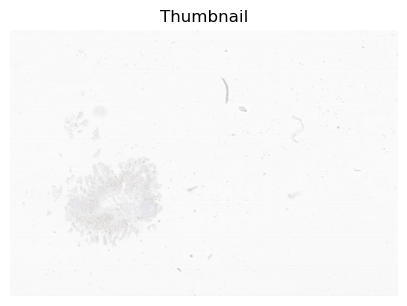

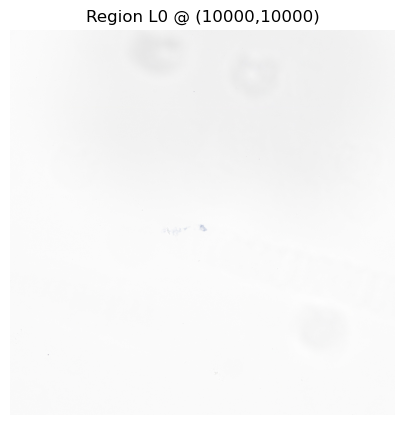

Best level for ~8x downsample: 1 size: (12042, 8270)


In [380]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import openslide

svs_path = "/home/icb/alioguz.can/projects/he_pathalogy/test_data/KO21000758#1#1#5_e3a796a0-7913-4498-f697-0ff222d00f5f_213926.svs"

# Open slide
slide = openslide.OpenSlide(svs_path)

# --- Basic info ---
print("Vendor:", slide.properties.get("openslide.vendor"))
print("Objective power:", slide.properties.get("aperio.AppMag"))
print("MPP X:", slide.properties.get("openslide.mpp-x"))
print("MPP Y:", slide.properties.get("openslide.mpp-y"))
print("Level count:", slide.level_count)
print("Level dimensions:", slide.level_dimensions)      # tuple per level (w, h)
print("Level downsamples:", slide.level_downsamples)    # relative to level 0
print(f"Patient: {Path(svs_path).stem.split('_')[0]}")

# --- Quick views ---
# 1) Thumbnail (keeps aspect; size is a suggestion)
thumb = slide.get_thumbnail((1024, 1024))  # PIL RGB
plt.figure(figsize=(5,5)); plt.imshow(thumb); plt.title("Thumbnail"); plt.axis("off"); plt.show()

# 2) Read a region from level 0 (top-left coordinates in level-0 pixels)
#    read_region returns a PIL RGBA image; drop alpha channel.
x0, y0 = 10000, 10000   # change as needed
w, h = 2048, 2048
level = 0
region_rgba = slide.read_region((x0, y0), level, (w, h))
region_rgb = np.array(region_rgba)[:, :, :3]  # (h, w, 3) uint8

plt.figure(figsize=(5,5)); plt.imshow(region_rgb); plt.title(f"Region L{level} @ ({x0},{y0})"); plt.axis("off"); plt.show()

# 3) Pick a best level for a target downsample (e.g., ~8x)
best_level = slide.get_best_level_for_downsample(8.0)
print("Best level for ~8x downsample:", best_level, "size:", slide.level_dimensions[best_level])

# Always close when done
slide.close()

Working at level 0 with size (48168, 33083)


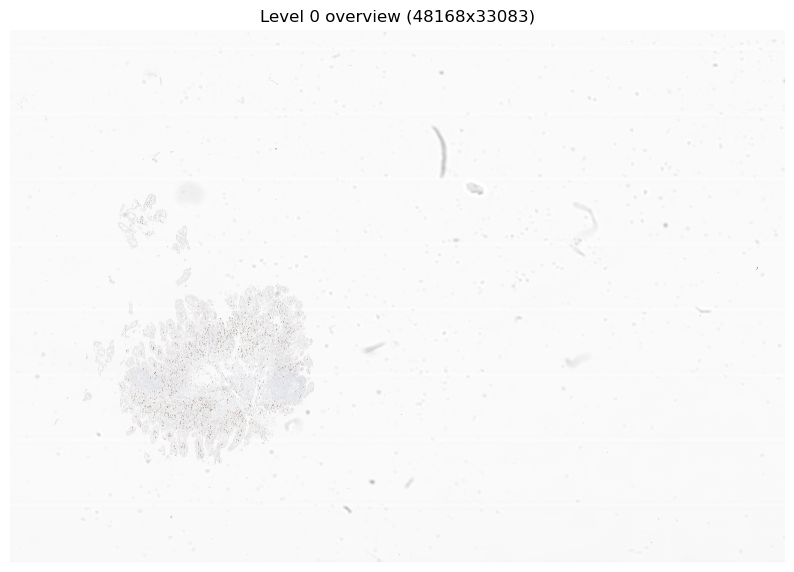

In [381]:
# Open slide
slide = openslide.OpenSlide(svs_path)

# choose a manageable level for tiling (e.g., level 1 or 2)
level = 0
dims = slide.level_dimensions[level]
print(f"Working at level {level} with size {dims}")

# read entire low-res image for overview
lowres = np.array(slide.read_region((0, 0), level, dims))[:, :, :3]

plt.figure(figsize=(10, 7))
plt.imshow(lowres)
plt.title(f"Level {level} overview ({dims[0]}x{dims[1]})")
plt.axis("off")
plt.show()

slide.close()

In [ ]:
# Path to your SVS file
svs_path = "/home/icb/alioguz.can/projects/he_pathalogy/test_data/KO21000758#1#1#5_e3a796a0-7913-4498-f697-0ff222d00f5f_213926.svs"
print(f"Patient: {Path(svs_path).stem.split('_')[0]}")
# Open the slide
slide = openslide.OpenSlide(svs_path)
level = 1  # use level 1 for manageable resolution

# Get dimensions at this level
width, height = slide.level_dimensions[level]
tile_size = 512

# Calculate how many tiles fit across the image
n_tiles_x = width // tile_size
n_tiles_y = height // tile_size

# Preallocate array (n, h, w, c)
image = np.zeros((n_tiles_x * n_tiles_y, tile_size, tile_size, 3), dtype=np.uint8)

print(f"Slide size at level {level}: {width}x{height}")
print(f"Extracting {n_tiles_x} x {n_tiles_y} = {n_tiles_x * n_tiles_y} tiles of {tile_size}x{tile_size}px")

# Loop over grid and read tiles
idx = 0
for y in range(n_tiles_y):
    for x in range(n_tiles_x):
        # Map tile coordinates to level 0 space
        x0 = int(x * tile_size * slide.level_downsamples[level])
        y0 = int(y * tile_size * slide.level_downsamples[level])

        # Read region and convert to NumPy RGB
        region = slide.read_region((x0, y0), level, (tile_size, tile_size))
        region = np.array(region)[:, :, :3]  # drop alpha
        image[idx] = region
        idx += 1

slide.close()

print(f"✅ Extracted {image.shape[0]} tiles -> array shape: {image.shape}")

Slide size at level 1: 12042x8270
Extracting 23 x 16 = 368 tiles of 512x512px
✅ Extracted 368 tiles -> array shape: (368, 512, 512, 3)


Tiles total: 368
Full tiles: 16
16 files have signal, subsetting to 22 files.


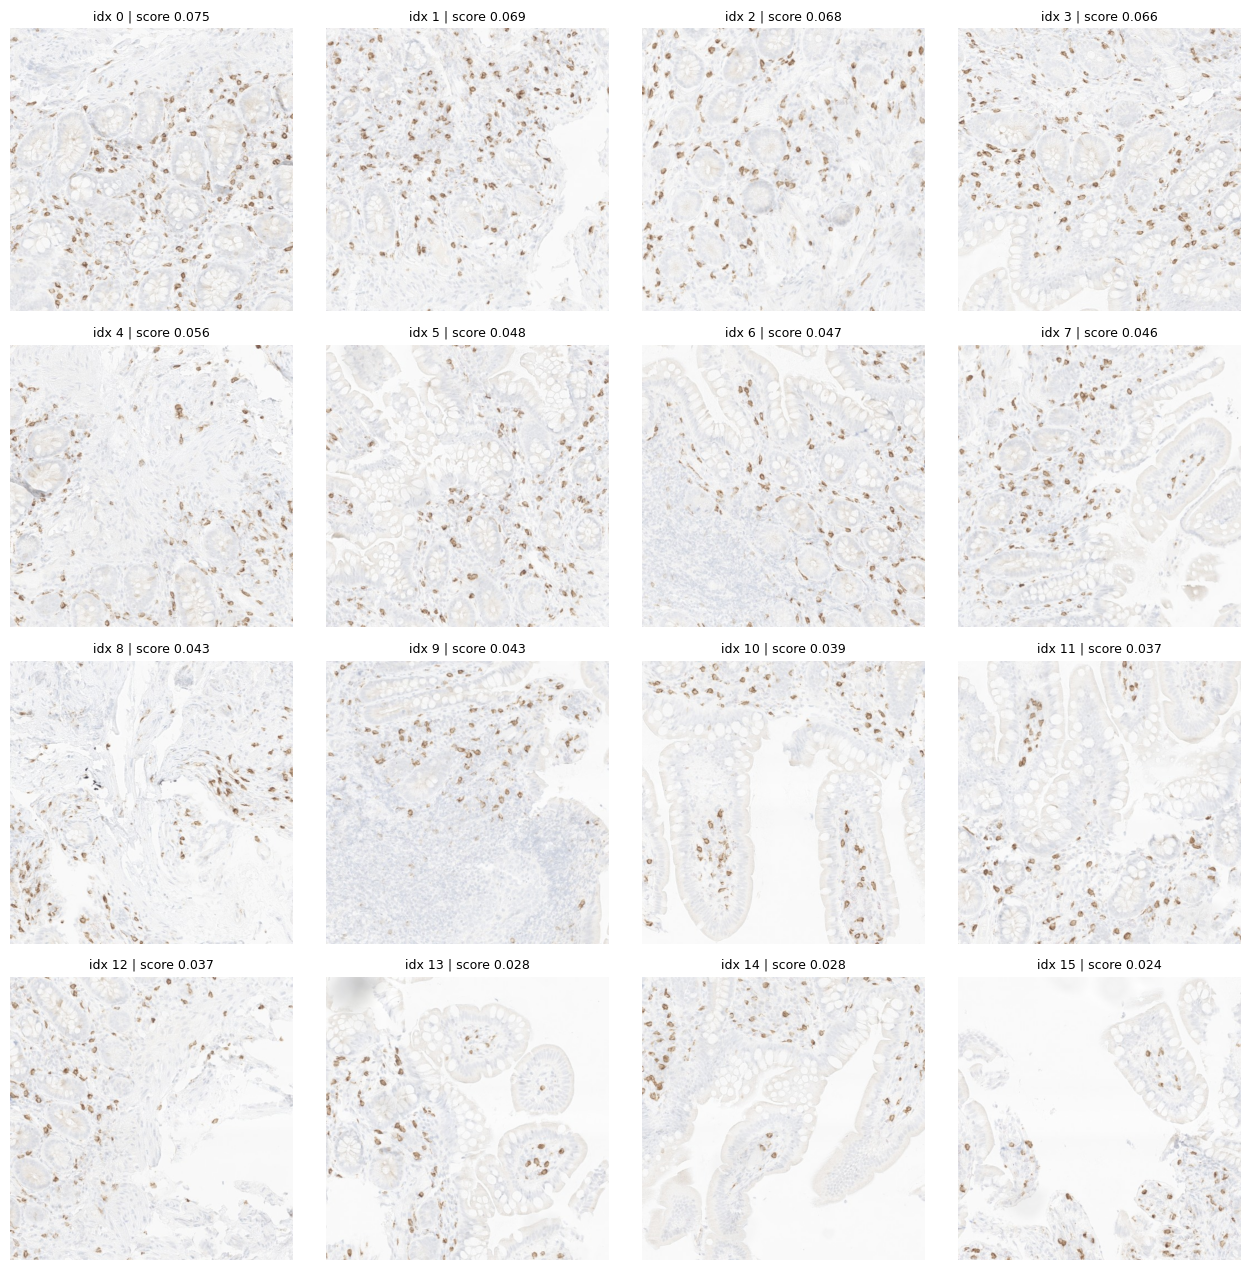

In [326]:
top_k = 22
full_idx, scores = find_full_tiles(image, SCALE_255=False)
print(f"{len(full_idx)} files have signal, subsetting to {top_k} files.")
full_idx = full_idx[:top_k]
plot_top_tiles(image[full_idx], scores["tissue_ratio"][full_idx], top_k=top_k)

In [359]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, exposure

# --- Parameters ---
plot_results = False   # set to False to disable visualization

for i in full_idx:
    # Extract blue channel only
    blue_tile = image[i, :, :, 2]  # shape (H, W)

    # Convert to optical density (OD)
    od = -np.log((blue_tile.astype(np.float32) + 1) / 255.0)

    # 1) Slight Gaussian smoothing
    od_s = filters.gaussian(od, sigma=1.0, preserve_range=True)

    # 2) Remove large-scale background (white tophat)
    od_corr = morphology.white_tophat(od_s, footprint=morphology.disk(15))

    # 3) Contrast normalize and threshold (Otsu)
    lo, hi = np.percentile(od_corr, (2, 99))
    lo = float(lo); hi = float(hi)
    if hi <= lo:
        hi = lo + 1e-6
    od_corr = exposure.rescale_intensity(od_corr, in_range=(lo, hi))
    thr = filters.threshold_otsu(od_corr)
    mask = od_corr > thr  # high OD = nuclei

    # 4) Postprocess mask
    mask = morphology.remove_small_objects(mask, min_size=20)
    mask = morphology.remove_small_holes(mask, area_threshold=20)

    # 5) Label connected components
    labeled = morphology.label(mask)
    n_objects = labeled.max()
    print(f"Tile {i}: Threshold {thr:.2f} → {n_objects} objects")

    # --- Optional visualization ---
    if plot_results:
        fig, axes = plt.subplots(1, 3, figsize=(14, 5))
        axes[0].imshow(blue_tile, cmap="gray")
        axes[0].set_title(f"Tile {i} - Blue channel")
        axes[0].axis("off")

        axes[1].imshow(od_corr, cmap="gray")
        axes[1].set_title("OD corrected (contrast-normalized)")
        axes[1].axis("off")

        axes[2].imshow(mask, cmap="gray")
        axes[2].set_title(f"Binary mask (thr={thr:.2f})")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

Tile 258: Threshold 0.38 → 183 objects
Tile 213: Threshold 0.38 → 187 objects
Tile 214: Threshold 0.38 → 150 objects
Tile 257: Threshold 0.39 → 148 objects
Tile 259: Threshold 0.38 → 156 objects
Tile 212: Threshold 0.41 → 129 objects
Tile 234: Threshold 0.42 → 113 objects
Tile 215: Threshold 0.41 → 128 objects
Tile 260: Threshold 0.40 → 125 objects
Tile 238: Threshold 0.42 → 103 objects
Tile 281: Threshold 0.42 → 83 objects
Tile 191: Threshold 0.43 → 82 objects
Tile 235: Threshold 0.41 → 106 objects
Tile 192: Threshold 0.43 → 68 objects
Tile 282: Threshold 0.44 → 73 objects
Tile 190: Threshold 0.41 → 67 objects
